In [1]:
from cv2 import cv2
import itertools
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [2]:
def open_img(path):
    img_bgr2 = cv2.imread(path)
    img_rgb = cv2.cvtColor(img_bgr2, cv2.COLOR_BGR2RGB)
    return img_rgb

In [3]:
def show_img(img, colormode='gray'):
    dim = img.shape
    colormap = 'gray' if len(dim) < 3 else None
    colormode = 'L' if len(dim) < 3 else 'RGB'
    img = Image.fromarray(np.uint8(img), colormode)
    plt.imshow(img, colormap)
    plt.axis('off')
    plt.show()

In [4]:
def euclidean_norm(vec):
    vec_squared = np.square(vec)
    sum_squared = np.sum(vec_squared)
    sum_sqrt = np.sqrt(sum_squared)
    return sum_sqrt

IMAGE SHAPE (321, 326, 3)


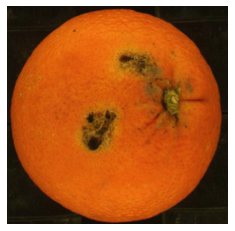

In [282]:
img = open_img('../test_imgs/orange_blasco.png')
print('IMAGE SHAPE', img.shape)
show_img(img)

In [283]:
size_x = img.shape[0]
size_y = img.shape[1]
# test = np.floor(np.random.rand(test_size, test_size, 3) * 255)
test = img
print('TEST SHAPE', test.shape)

TEST SHAPE (321, 326, 3)


In [304]:
# DISJOINT BLOCKS PARTITIONS
n = 5  # Window size

# Corner window values
c_values1 = [i*n for i in range(test.shape[0] // n)]
c_values2 = [((i+1)*n) - 1 for i in range(test.shape[0] // n)]

# Corner window combinations
x1y1 = list(itertools.product(c_values1, repeat=2))
x2y2 = list(itertools.product(c_values2, repeat=2))

# print(x1y1)
# print(x2y2)
# show_img(test)

# Save disjoint blocks
blocks = []
for i in range(len(x1y1)):
    blocks.append(test[x1y1[i][0]:x2y2[i][0]+1, x1y1[i][1]:x2y2[i][1]+1])
    # show_img(blocks[i])

In [310]:
blocks[i].shape[1]

5

In [320]:
blocks[0]

array([[[20, 18, 12],
        [18, 17, 11],
        [17, 16, 10],
        [17, 15, 10],
        [17, 15, 10]],

       [[20, 16, 12],
        [19, 15, 11],
        [18, 15, 11],
        [18, 15, 11],
        [19, 15, 11]],

       [[18, 14,  9],
        [18, 14,  9],
        [18, 14,  9],
        [19, 15, 10],
        [20, 16, 11]],

       [[21, 16,  9],
        [21, 16,  8],
        [22, 17,  9],
        [24, 19, 11],
        [25, 20, 12]],

       [[27, 21, 10],
        [27, 21, 10],
        [28, 23, 11],
        [30, 25, 13],
        [32, 26, 15]]], dtype=uint8)

In [328]:
blocks[0][3, 0, 0]

21

In [329]:
peer_groups_index = []
d = 20
for i in range(len(blocks)):
    ri = blocks[i][0, n // 2, n // 2]
    gi = blocks[i][1, n // 2, n // 2]
    bi = blocks[i][2, n // 2, n // 2]
    xi = np.array([ri, gi, bi])
    # print('CENTRAL PIXEL: ', xi)
    xi_peer_group_index = []
    for j in range(blocks[i].shape[1]):
        for k in range(blocks[i].shape[2]):
            rj = blocks[i][0,j,k]
            gj = blocks[i][1,j,k]
            bj = blocks[i][2,j,k]
            xj = np.array([rj, gj, bj])
            # MEMBERS OF PEER GROUP
            distance_btw = euclidean_norm(xi) - euclidean_norm(xj)
            is_member = distance_btw <= d
            if is_member:
                xi_peer_group_index.append((j,k))
            # print('WINDOW PIXELS: ', xj)
    peer_groups_index.append(xi_peer_group_index)

In [330]:
# non-corrupted = -1
# non-diagnosed = 0
# corrupted = 2
m = 2
peer_groups_state = []
for i in range(len(blocks)):
    state = np.zeros((blocks[i].shape[0], blocks[i].shape[1])) + 2
    pg_cardinality = len(peer_groups_index[i])
    is_non_corrupted = pg_cardinality >= (m + 1)
    if is_non_corrupted:
        for j in range(len(peer_groups_index[i])):
            ix = peer_groups_index[i][j][0]
            jx = peer_groups_index[i][j][1]
            state[ix,jx] = -1
        state[n // 2, n // 2] = -1
    peer_groups_state.append(state)

In [331]:
for i in range(1):
    print('*'*10, 'BLOCK', '*'*10)
    corrupted = np.where(peer_groups_state[i] == 2)
    corrupted_rows = corrupted[0]
    corrupted_columns = corrupted[1]
    
    non_corrupted = np.where(peer_groups_state[i] == -1)
    non_corrupted_rows = non_corrupted[0]
    non_corrupted_columns = non_corrupted[1]
    
    non_corrupted_pixels = []
    for j in range(len(non_corrupted_rows)):
        nc_pixel = np.array([
            blocks[i][0, non_corrupted_rows[j], non_corrupted_columns[j]],
            blocks[i][1, non_corrupted_rows[j], non_corrupted_columns[j]],
            blocks[i][2, non_corrupted_rows[j], non_corrupted_columns[j]]
        ])
        non_corrupted_pixels.append(nc_pixel)
    AMF = np.mean(non_corrupted_pixels, axis=0)
    for j in range(len(corrupted_rows)):
        blocks[i][0, corrupted_rows[j], corrupted_columns[j]] = AMF[0]
        blocks[i][1, corrupted_rows[j], corrupted_columns[j]] = AMF[1]
        blocks[i][2, corrupted_rows[j], corrupted_columns[j]] = AMF[2]

********** BLOCK **********


IndexError: index 3 is out of bounds for axis 2 with size 3

In [302]:
left_x = size_x % n
left_y = size_y % n
new_size_x = size_x - left_x
new_size_y = size_y - left_y

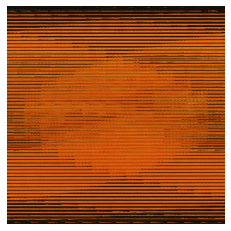

In [303]:
show_img(np.asarray(blocks).flatten().reshape((new_size_x, new_size_x, 3)))